# 시계열 예측 공부 
<br>시계열 예측은 과거 패턴으로 미래 패턴을 예측하는 것 <br>
링크를 참고해서 시계열 예측모델 실습했다. <br>
링크: https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/intro.html <br>

### 1. 데이터 탐색

<br>
1) 빈 폴더 만들어서 오른 마우스 클릭하면 git bash here 선택 <br>
2) 검은 창 뜨면 git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils 입력해서 파일 다운로드 <br>
3) python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries 입력해서 데이터 다운로드 <br>
<br>
* time_series_covid19_confirmed_global 파일은 아래 링크에서 새로운 자료로 업데이터해서 받는 것 가능 <br>
https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases/resource/00fa0e37-961b-4767-a5ce-e7ab4e2c921c




In [1]:
import pandas as pd
path = './covid_data/'
all = pd.read_csv(path + 'covid_19_data.csv')
confirmed = pd.read_csv(path + 'time_series_covid19_confirmed_global.csv')
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,157841,157878,157887,157895,157951,157967,157998,158037,158056,158084
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,206616,206935,207221,207542,207709,207709,208352,208899,208899,210224
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,215430,215723,216098,216376,216637,216930,217265,217647,218037,218432
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,21372,21571,21730,21730,21730,22332,22540,22823,23122,23740
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,67199,68362,70221,71142,71752,71752,76787,78475,79871,81593


#### confirmed data에서 한국 데이터만 뽑아서 날짜별 확진률 그래프 그리기


In [2]:
import datetime

confirmed['Country/Region'].unique() # 한국 이름 찾기
kor = confirmed[confirmed['Country/Region'] == 'Korea, South' ]
kor = kor.T  # 행렬 바꿈
kor = kor[4:]  # 윗단 필요없는데이터 제거


In [3]:
# 엑셀이 자기 마음대로 날짜 형식을 잘못 인지해서 변경 이상하게 한다. 01을 2001이라고 되어 있음. 이거 한번에 고치는 법 없나?
v = []
for i in kor.index:
    r = i.replace('200', '')   # 01, 02.... 09 월 날짜 변경
    r = r.replace('2010', '10') # 10월 날짜 변경
    r = r.replace('2011', '11') # 11월 날짜 변경
    r = r.replace('2012', '12') # 12월 날짜 변경
    v.append(r)
kor.index = v
kor.index = pd.to_datetime(kor.index)  # to_datetime으로 str -> 날짜 형식으로 변환

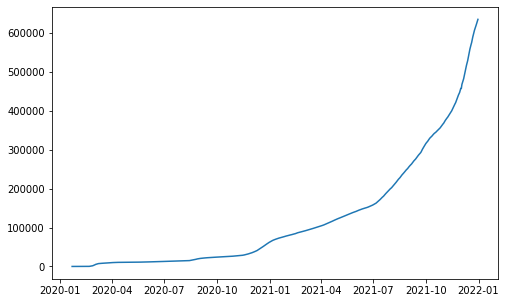

In [4]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
plt.plot( kor.index, kor)

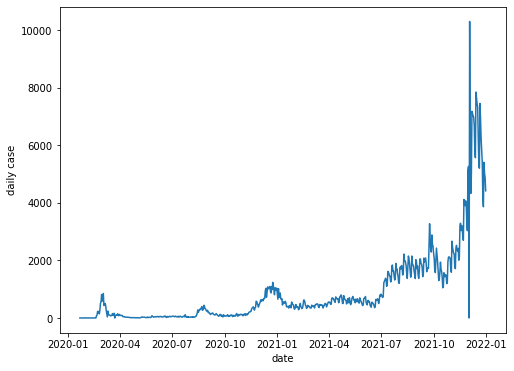

In [5]:
kor.diff() # 후단 데이터에서 이전 데이터 값을 빼줌
kor_daily = kor.diff().fillna(kor.iloc[0]) # diff를 적용하고 결측치는 첫줄에만 생기니까 결측치를 data첫줄 값으로 채움
kor_daily = kor_daily.astype('int')  # 데이터의 형식이 다른경우 int로 변환가능
ax, fig = plt.subplots(figsize = (8, 6))
plt.plot(kor_daily)
plt.xlabel('date')
plt.ylabel('daily case')
plt.show()

#### 2. 데이터 전처리 <br>
t-k 부터 t-1 까지의 데이터로 t에서의 값을 예측하는 것을 one step prediction이라고 한다. <br>
시계열 데이터를 입력데이터/ 타켓데이터로 나눠보자. <br>

 - 링크에서는 k를 5로 했음.
 - kor_daily 데이터를 사용. 전체 샘플갯수 710개

In [79]:
import numpy as np
test = []
test.append(kor_daily[0:5].values)
np.array(test)

array([[[1],
        [0],
        [1],
        [0],
        [1]]])

In [80]:
import numpy as np

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):    # 710 - 5  에서
        x = data.iloc[i:(i+seq_length)].values     # [0: 0+5], [1: 6], [2:7].....
        y = data.iloc[i+seq_length].values         #[5], [6], [7], []...
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(kor_daily, seq_length)

In [81]:
X.shape, y.shape

((705, 5, 1), (705, 1))

#### train, test set 분리는train_test_split을 이용. <br>
shuffle = False: 순차적으로 split <br>
shuffle = True: 무작위로 섞어서 split <br>


In [90]:
from sklearn.model_selection import train_test_split

xtrain_val, xtest, ytrain_val, ytest = train_test_split(X, y, test_size = 0.2)
xtrain, xval, ytrain, yval = train_test_split(xtrain_val, ytrain_val, test_size = 0.2)

In [97]:
print(xtrain.shape, xval.shape, xtest.shape)
print(ytrain.shape, yval.shape, ytest.shape)

torch.Size([451, 5, 1]) torch.Size([113, 5, 1]) torch.Size([141, 5, 1])
torch.Size([451, 1]) torch.Size([113, 1]) torch.Size([141, 1])


#### 3. 데이터 변환 <br>
1) train, test 셋 각각 min max scailing <br>
 - lstm 모델을 학습 시키기 전에 데이터를 0~1사이로 스케일링 했다. <br>
 - 데이터 변형하면 사라지느 정보하 target 예측에 중요하다면 스케일링을 안하는게 낫다. 상황에 따라 다름. <br>
 - standardizing the inputs can make training faster and reduce the chances of getting stuck in local optima <br>

왜 스케일링이 모델 빠르게 학습, 국소지역에서 학습 멈추는 거 막아주는지 설명: http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html <br>

2) torch 형태로 변환 <br>
 - array 형식의 데이터 셋을 torch형태로 변환시킴 



In [92]:
MIN = xtrain.min()
MAX = xtrain.max()

def MinMaxScale(array, min, max):
    scaled = (array - min)/(max -min)
    return(scaled)
xtrain = MinMaxScale(xtrain, MIN, MAX)
ytrain = MinMaxScale(ytrain, MIN, MAX)
xtest = MinMaxScale(xtest, MIN, MAX)
ytest = MinMaxScale(ytest, MIN, MAX)

#Tensor 형태로 변환
import torch
from torch import nn, optim
def make_Tensor(array):
    '''
    array 데이터를 받아서 torch 형태로 변환시키고,
    float으로 소숫점 아랫자리를 4개로 줄여줌
    '''
    return torch.from_numpy(array).float()

xtrain = make_Tensor(xtrain)
ytrain = make_Tensor(ytrain)
xval = make_Tensor(xval)
yval = make_Tensor(yval)
xtest = make_Tensor(xtest)
ytest = make_Tensor(ytest)

#### 4. LSTM 모델 구축 <br>
1) class로 모델 구성하는 이유 <br>
 - 변수를 특정 스코프에 소속시키는 것이 가능하다. <br>
 - 재사용할 수 있다(무슨뜻?)
 - 함수를 다시 호출하는 것이 편리 <br>
 
2) 메소드 <br>
 - class에 내장된 def들을 메소드라 부름 <br>
 
3) __init__() 의 역할 <br>
 - 데이터를 초기화 하는 역할 <br>
 - init 앞에는 self를 제일 먼저 써준다 ex) __init__(self) <br>
 - self 옆에는 해당 class에서 사용할 인자들을 적는다. (self, var1, var2...) <br>
 
4) self <br>
 - class 선언을 할 때는 인자에 sel를 붙여주는 것이 규칙이고, 사용할 때는 self를 안쓴다. <br>
 
5) super <br> 
 - 다른 클래스를 해당 클래스에서 사용할 때 사용함
 
6) nn.module <br>
 - torch에서 import했음 (from torch import nn)
 - torch에서 제공하는 nn.module 클래스임.
 - 구축하려는 lstm 모델이 nn.module 클래스를 상속받았다. <br>
class 참고: https://www.inflearn.com/questions/4642  <br>
super 참고: https://realpython.com/python-super/#an-overview-of-pythons-super-function <br>
nn.modeul 참고: https://wikidocs.net/60036


5) super 예시 <br>
Square 클래스는 Retangle 클래스를 받고, super 뒤에 필요한 변수인 length, width 2개 값을 length, length라고 넣어줬다.  <br>
그래서 s.area하니까 retangle 클래스 사용 가능했다.(아래 예시 참고) <br>
covid 예측 모델에서는 nn.module클래스에서 nn.linear와 nn.lstm 모델을 사용했다 

In [93]:
# super 예시
class Rectangle:
    def __init__(self, length, width):
        self.length = length
        self.width = width

    def area(self):
        return self.length * self.width

    def perimeter(self):
        return 2 * self.length + 2 * self.width


# Here we declare that the Square class inherits from the Rectangle class
class Square(Rectangle):
    def __init__(self, length):
        super().__init__(length, length)

In [61]:
Square(length = 4).area()

16

class 변수는 초기화 함수 __init__, 내부 값을 모두 zero로 만들어주는 reset_hidden_state함수, 예측에 쓰는 forward 함수로 이루어져 있따. <br>
새로운 sequence 입력시 기존 sequence는 잊어버리려고 reset_hidden_state를 쓴다고 한다.

In [94]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [95]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [96]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    xtrain,
    ytrain,
    xval,
    yval,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.09825805428142591 val loss: 711.4744262695312
Epoch 10 train loss: 0.01349061727575429 val loss: 710.5325927734375
Epoch 20 train loss: 0.013287109723394662 val loss: 710.5106201171875
Epoch 30 train loss: 0.013171400505989509 val loss: 710.493896484375
Epoch 40 train loss: 0.01324049536297005 val loss: 710.4891357421875
Epoch 50 train loss: 0.013132904630805884 val loss: 710.493896484375
Epoch 60 train loss: 0.013264178728259905 val loss: 710.4890747070312
Epoch 70 train loss: 0.013174165573803307 val loss: 710.4837646484375
Epoch 80 train loss: 0.013209835468598346 val loss: 710.4759521484375
Epoch 90 train loss: 0.013236673048760911 val loss: 710.4663696289062


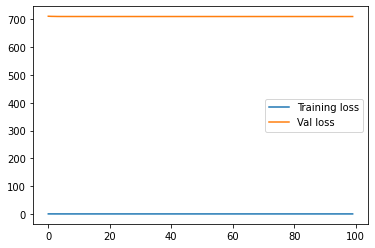

In [98]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

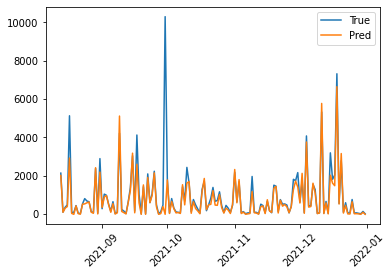

In [99]:
pred_dataset = xtest

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

plt.plot(kor_daily.index[-len(ytest):], np.array(ytest) * MAX, label='True')
plt.plot(kor_daily.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()